In [1]:
from fastai.vision.all import *

In [2]:
import albumentations
from efficientnet_pytorch import EfficientNet

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)
path

Path('/home/sandmann/.fastai/data/mnist_sample')

In [4]:
path = Path('/home/sandmann/.fastai/data/cassava-leaf-disease-classification/')
Path.BASE_PATH = path
path.ls()

(#7) [Path('sample_submission.csv'),Path('test_images'),Path('train_images'),Path('label_num_to_disease_map.json'),Path('test_tfrecords'),Path('train_tfrecords'),Path('train.csv')]

In [5]:
df_train = pd.read_csv(path/'train.csv')
df_train.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [6]:
class AlbumentationsTransform(DisplayedTransform):
    def __init__(self, aug): self.aug = aug
    def encodes(self, img:PILImage):
        aug_img = self.aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [7]:
class AlbumentationsTransform(RandTransform):
    split_idx,order = None,2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
        
    def encodes(self, img:PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [8]:
def get_train_aug(): return albumentations.Compose([
    albumentations.RandomResizedCrop(256,256),
    albumentations.Transpose(p=0.5),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.ShiftScaleRotate(p=0.5),
    albumentations.HueSaturationValue(0.2, 0.2, 0.2, p=0.5),
    albumentations.RandomBrightnessContrast((-0.1,0.1), (-0.1,0.1), p=0.5),
    albumentations.CoarseDropout(p=0.5),
    albumentations.Cutout(p=0.5)
])

In [9]:
def get_valid_aug(): return albumentations.Compose([
    albumentations.CenterCrop(256,256, p=1.),
    albumentations.Resize(256,256)
], p=1.)

In [10]:
item_tfms = AlbumentationsTransform(get_train_aug(), get_valid_aug())

/home/sandmann/anaconda3/envs/fastai/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:689: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


In [11]:
set_seed(999)

In [12]:
path.ls()

(#7) [Path('sample_submission.csv'),Path('test_images'),Path('train_images'),Path('label_num_to_disease_map.json'),Path('test_tfrecords'),Path('train_tfrecords'),Path('train.csv')]

In [13]:
df_train = pd.read_csv(path/'train.csv')
df_train['image_id'] = df_train['image_id'].apply(lambda x: f'train_images/{x}')
df_train.head()

,image_id,label
0,train_images/1000015157.jpg,0
1,train_images/1000201771.jpg,3
2,train_images/100042118.jpg,1
3,train_images/1000723321.jpg,1
4,train_images/1000812911.jpg,3


In [14]:
with open(path/'label_num_to_disease_map.json', 'r') as f:
    idx2lbl = json.load(f)

In [15]:
idx2lbl

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

In [16]:
df_train['label'] = df_train['label'].astype('string')

In [17]:
df_train['label'].replace(idx2lbl, inplace=True)

In [18]:
df_train.head()

,image_id,label
0,train_images/1000015157.jpg,Cassava Bacterial Blight (CBB)
1,train_images/1000201771.jpg,Cassava Mosaic Disease (CMD)
2,train_images/100042118.jpg,Cassava Brown Streak Disease (CBSD)
3,train_images/1000723321.jpg,Cassava Brown Streak Disease (CBSD)
4,train_images/1000812911.jpg,Cassava Mosaic Disease (CMD)


In [41]:
def get_x(row): return path/row['image_id']
def get_y(row): return row['label']

In [42]:
dblock = DataBlock((ImageBlock, CategoryBlock),
                 get_x = get_x,
                 get_y = get_y,
                 splitter = RandomSplitter(0.2),
                 item_tfms = item_tfms,
                 batch_tfms = [Normalize.from_stats(*imagenet_stats)])

In [20]:
dls = dblock.dataloaders(df_train, bs=16, val_bs=32)

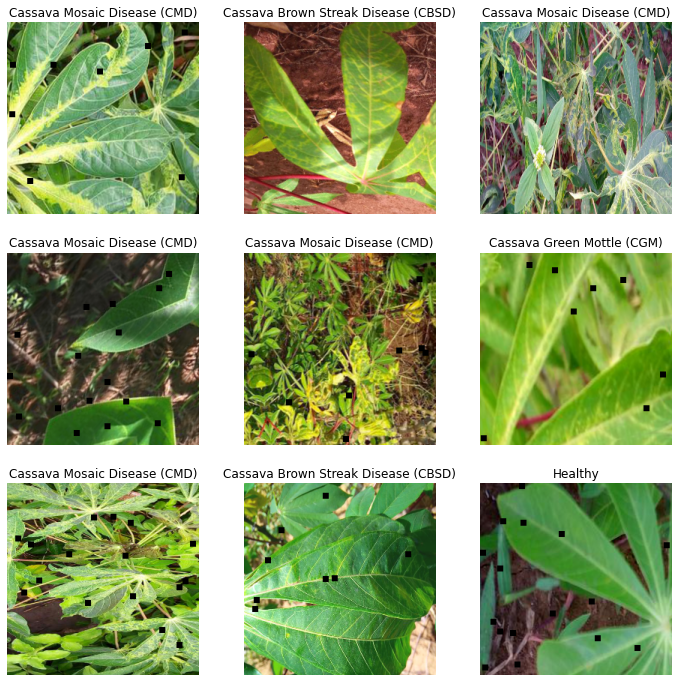

In [21]:
dls.show_batch(figsize=(12,12))

In [22]:
class LeafModel(Module):
    def __init__(self, num_classes):
        self.effnet = EfficientNet.from_pretrained('efficientnet-b3')
        self.dropout = nn.Dropout(0.1)
        self.out = nn.Linear(1536, num_classes)
        
    def forward(self, image):
        batch_size,*_ = image.shape
        
        x = self.effnet.extract_features(image)
        x = F.adaptive_avg_pool2d(x,1).reshape(batch_size, -1)
        outputs = self.out(self.dropout(x))
        return outputs

In [23]:
net = LeafModel(dls.c)

Loaded pretrained weights for efficientnet-b3


In [24]:
learn = Learner(dls, net, CrossEntropyLossFlat(), metrics=[accuracy]).to_fp16()

SuggestedLRs(valley=0.0003311311302240938)

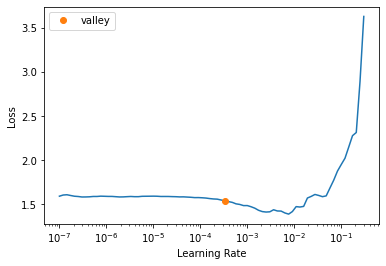

In [25]:
learn.lr_find()

In [30]:
learn.fit_flat_cos(2, 3e-4, pct_start=0.0, cbs=[EarlyStoppingCallback(patience=3), SaveModelCallback()])

epoch,train_loss,valid_loss,accuracy,time
0,0.576367,0.503579,0.826595,08:35
1,0.458170,0.461352,0.841318,08:34


Better model found at epoch 0 with valid_loss value: 0.5035792589187622.
Better model found at epoch 1 with valid_loss value: 0.46135249733924866.


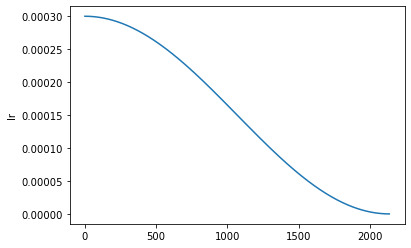

In [33]:
learn.recorder.plot_sched()

In [36]:
learn = Learner(dls, net, CrossEntropyLossFlat(), metrics=[accuracy]).to_fp16()

In [37]:
learn.fit_one_cycle(2, 3e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.498944,0.548937,0.816079,08:44
1,0.431894,0.435539,0.854405,08:40


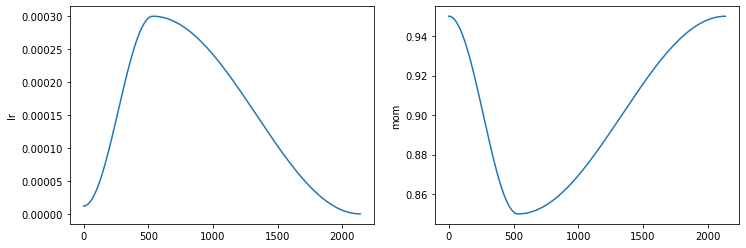

In [39]:
learn.recorder.plot_sched()

In [ ]:
learn.export('baseline')